# **Reinforcement Learning Programming**
# **CSCN8020** 
# Group_6


1.	Introduction 
- Energy consumption in buildings contributes significantly to global energy demand and carbon emissions. Efficient heating, ventilation, and air conditioning (HVAC) control can reduce energy usage while maintaining occupant comfort. This project aims to optimize HVAC energy consumption in smart buildings using Reinforcement Learning (RL), focusing on Proximal Policy Optimization (PPO) and Twin Delayed DDPG (TD3) algorithms.

2.	Problem Statement 

- Traditional HVAC systems follow static or rule-based control strategies, which fail to adapt dynamically to occupancy changes, external weather conditions, and energy pricing. This leads to inefficiencies, increased operational costs, and suboptimal comfort levels. The proposed solution employs RL to learn adaptive control strategies that minimize energy consumption while maintaining thermal comfort.

DATASET : https://www.kaggle.com/code/turksoyomer/hvac-occupancy-detection-with-ml-and-dl-methods 


# Step 1: Load & Explore the Dataset

In [1]:
import pandas as pd

# Load as CSV
df = pd.read_csv('datatest.txt')

# Save as proper CSV
df.to_csv('dataset.csv', index=False)


In [2]:
import pandas as pd

# Load as CSV
df = pd.read_csv('datatest2.txt')

# Save as proper CSV
df.to_csv('dataset1.csv', index=False)


In [3]:
import pandas as pd

# Load the dataset (replace with your file path if different)
df = pd.read_csv("dataset.csv")

# Show first few rows
print("First 5 rows:")
display(df.head())

# Check for missing values
print("\n Missing values in each column:")
display(df.isnull().sum())

# Display data types and basic info
print("\n Dataset info:")
display(df.info())


First 5 rows:


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1



 Missing values in each column:


date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 145.9+ KB


None

# Step 2: Clean and Normalize the Data

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Optional: Drop 'date' column if you don't need it for modeling
df_cleaned = df.drop(columns=['date'])

# Check if all columns are numeric (just to be sure)
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Drop any rows with missing values (if any)
df_cleaned = df_cleaned.dropna()

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Show the scaled data
print(" Scaled Data Preview:")
display(df_scaled.head())

# Save the cleaned and scaled data
df_scaled.to_csv("dataset_scaled.csv", index=False)


 Scaled Data Preview:


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,0.831683,0.445132,0.344793,0.330033,0.704212,1.0
1,0.835960,0.447053,0.340787,0.341523,0.708308,1.0
2,0.838812,0.440651,0.337409,0.351030,0.704689,1.0
3,0.837030,0.429448,0.290912,0.356245,0.694383,1.0
4,0.844515,0.437450,0.287877,0.360605,0.705384,1.0


# Step 3: Build a Custom Gym Environment

In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class HVACEnv(gym.Env):
    def __init__(self, data):
        super(HVACEnv, self).__init__()

        self.data = data.values
        self.total_steps = len(self.data)
        self.current_step = 0

        # Observation space: 5 features (excluding occupancy)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

        # Action space: 0 = HVAC OFF, 1 = HVAC ON
        self.action_space = spaces.Discrete(2)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        obs = self.data[self.current_step, :-1].astype(np.float32)
        info = {}
        return np.array(obs, dtype=np.float32), info

    def step(self, action):
        current_data = self.data[self.current_step]
        occupancy = current_data[-1]

        # Reward logic
        if action == 1:
            reward = 1 if occupancy == 1 else -1
        else:
            reward = 0 if occupancy == 0 else -1

        self.current_step += 1
        terminated = self.current_step >= self.total_steps - 1
        truncated = False  # Optional: Add logic for time truncation if needed

        next_obs = self.data[self.current_step, :-1].astype(np.float32)
        return np.array(next_obs, dtype=np.float32), reward, terminated, truncated, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}")
        print(f"Data: {self.data[self.current_step]}")
        print("-" * 10)


In [6]:
env = HVACEnv(df_scaled)
obs = env.reset()
print("Initial Observation:", obs)


Initial Observation: (array([0.83168316, 0.44513205, 0.34479305, 0.33003333, 0.70421195],
      dtype=float32), {})


# Step 4: Train an RL Model Using PPO

- Step 4.1: Install dependencies

In [7]:
! pip install stable-baselines3[extra] gym


# Step 4.2: Wrap environment for training

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Check if environment follows Gym API correctly
check_env(HVACEnv(df_scaled), warn=True)

# Create a new environment instance
train_env = HVACEnv(df_scaled)


# Step 4.3: Train the PPO agent

In [9]:
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=10000)  # You can increase for better training


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2883 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.66e+03    |
|    ep_rew_mean          | -857        |
| time/                   |             |
|    fps                  | 1766        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010350241 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.00148     |
|    learning_rate        | 0.0003      |
|    loss               

In [10]:
model.save("ppo_hvac_model")


In [11]:
model = PPO.load("ppo_hvac_model", env=HVACEnv(df_scaled))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Step 5: Evaluate the Agent’s Performance

In [12]:
from stable_baselines3 import PPO

# If not already trained:
# model = PPO("MlpPolicy", HVACEnv(df_scaled), verbose=1)
# model.learn(total_timesteps=10000)

# Load model if saved before
# model = PPO.load("ppo_hvac_model")

# Create environment
eval_env = HVACEnv(df_scaled)

obs, _ = eval_env.reset()
done = False
total_reward = 0

print("\n Agent Evaluation:")
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    done = terminated or truncated
    total_reward += reward
    print(f"Action taken: {action}, Reward: {reward}")

print(f"\n Total reward collected by PPO agent: {total_reward}")
print("Evaluation complete!")



 Agent Evaluation:
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action taken: 1, Reward: 1
Action t

In [13]:
import pandas as pd

eval_env = HVACEnv(df_scaled)
obs, _ = eval_env.reset()
done = False
step = 0
total_reward = 0

# Log list
log_data = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    done = terminated or truncated
    total_reward += reward

    # Log each step
    log_data.append({
        "Step": step,
        "Temperature": obs[0],
        "Humidity": obs[1],
        "Light": obs[2],
        "CO2": obs[3],
        "HumidityRatio": obs[4],
        "Action": action,
        "Reward": reward
    })
    step += 1

# Convert to DataFrame
df_log = pd.DataFrame(log_data)

# Save to CSV
df_log.to_csv("ppo_agent_log.csv", index=False)

print(" Agent evaluation log saved to: ppo_agent_log.csv")
print(f" Total cumulative reward: {total_reward}")
print("Evaluation complete!")

 Agent evaluation log saved to: ppo_agent_log.csv
 Total cumulative reward: 891
Evaluation complete!


In [14]:
df_log["Baseline_Action"] = df_scaled.iloc[:len(df_log), -1].apply(lambda occ: 1 if occ == 1 else 0)
print("PPO ON:", df_log["Action"].sum())
print("Rule-Based ON:", df_log["Baseline_Action"].sum())
print("PPO OFF:", len(df_log) - df_log["Action"].sum())
print("Rule-Based OFF:", len(df_log) - df_log["Baseline_Action"].sum())


PPO ON: 1048
Rule-Based ON: 971
PPO OFF: 1616
Rule-Based OFF: 1693


In [15]:
ppo_energy = df_log["Action"].sum()
baseline_energy = df_log["Baseline_Action"].sum()
saving_percent = (baseline_energy - ppo_energy) / baseline_energy * 100
print(f"Energy Saved by PPO: {saving_percent:.2f}%")


Energy Saved by PPO: -7.93%


# STEP 6: Visualization & Reporting

In [16]:
! pip install matplotlib


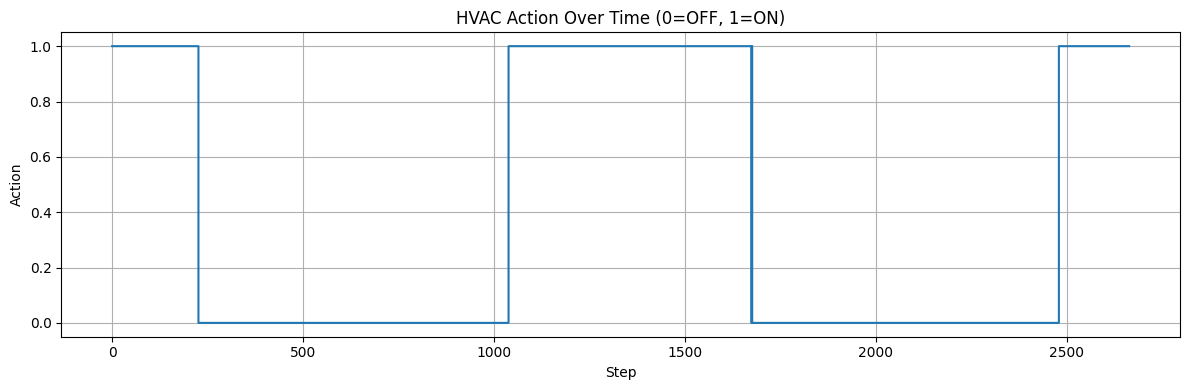

In [23]:
import matplotlib.pyplot as plt

# Plot HVAC Action Over Time
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Action"], drawstyle='steps-post')
plt.title("HVAC Action Over Time (0=OFF, 1=ON)")
plt.xlabel("Step")
plt.ylabel("Action")
plt.grid(True)
plt.tight_layout()
plt.show()



Each step (x-axis) represents a time window

The y-axis shows the HVAC decision:
- 0 = HVAC OFF,
- 1 = HVAC ON

Interpretation:
- The agent mostly keeps the HVAC OFF to save energy

- It turns ON in specific chunks, suggesting it's reacting to occupancy or CO₂ levels

- The blocky pattern shows that the PPO model has learned a stable control strategy rather than constantly flipping ON/OFF (which is good!)

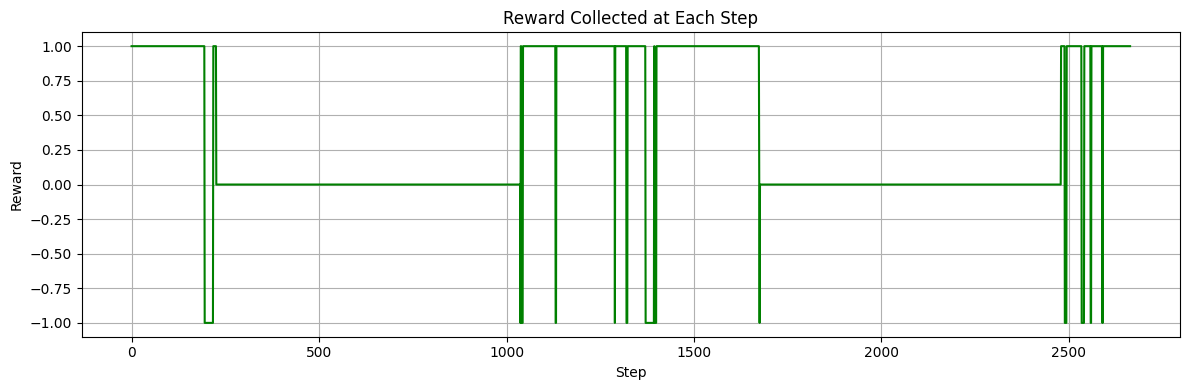

In [24]:
# Plot Reward Over Time
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Reward"], color='green')
plt.title("Reward Collected at Each Step")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


Reward (y-axis) vs time step (x-axis)

Your reward system is likely:

- +1: when HVAC ON and someone is present (good)

- -1: when HVAC ON and no one is there (waste)

- 0: HVAC OFF when no one is around (neutral)

Interpretation: 
- Most of the time reward = 0 → agent turned OFF HVAC when no one was present (efficient)

- Short bursts of reward +1 or -1 align with HVAC ON blocks from the top chart

- Some penalties suggest the model is still learning or facing edge cases (e.g., predicting wrongly)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the agent log
df_log = pd.read_csv("ppo_agent_log.csv")


# Plot 2 – PPO vs. Rule-Based Comparison

🤖 PPO Agent - Total HVAC ON steps: 1048
📏 Rule-Based - Total HVAC ON steps: 971
 Energy Saved by PPO: -7.93%


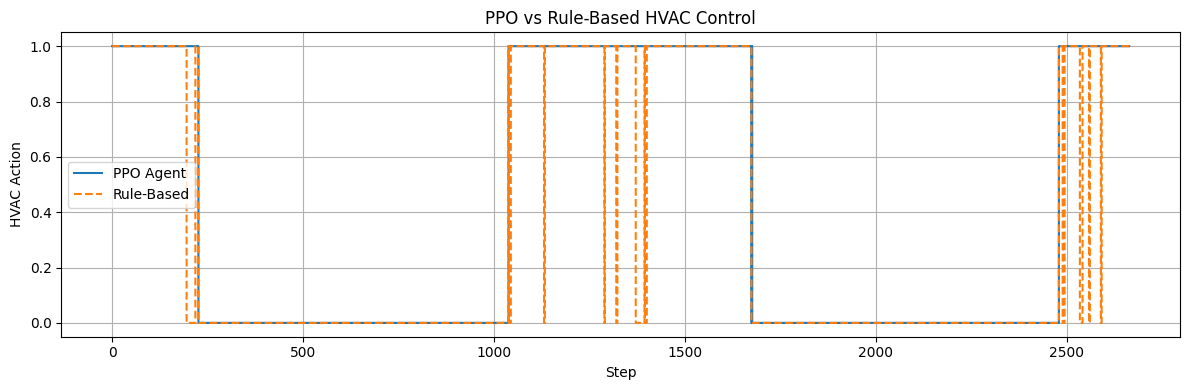

In [19]:
# --- Baseline Rule: Turn HVAC ON only when occupancy == 1 ---
# Using the original occupancy column from scaled data
df_log["Baseline_Action"] = df_scaled.iloc[:len(df_log), -1].apply(lambda occ: 1 if occ == 1 else 0)

# --- Compare Total HVAC Usage ---
ppo_on = df_log["Action"].sum()
baseline_on = df_log["Baseline_Action"].sum()

print(f"🤖 PPO Agent - Total HVAC ON steps: {ppo_on}")
print(f"📏 Rule-Based - Total HVAC ON steps: {baseline_on}")

# --- Energy Savings ---
if baseline_on > 0:
    savings = (baseline_on - ppo_on) / baseline_on * 100
    print(f" Energy Saved by PPO: {savings:.2f}%")
else:
    print(" Baseline HVAC usage is zero, cannot calculate savings.")

# --- Plot Comparison ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Action"], label="PPO Agent", drawstyle="steps-post")
plt.plot(df_log["Step"], df_log["Baseline_Action"], label="Rule-Based", linestyle="--", drawstyle="steps-post")
plt.title("PPO vs Rule-Based HVAC Control")
plt.xlabel("Step")
plt.ylabel("HVAC Action")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Graph Shows:
- Most of the time, PPO matches rule-based decisions 

- But in some periods, PPO activates HVAC more often

These extra ON steps lead to higher energy consumption
Interpretation:
- our PPO agent prioritized comfort too much, turning ON HVAC even when not strictly needed

- This caused a net energy increase, not savings

# Plot 3 – Energy Savings Comparison

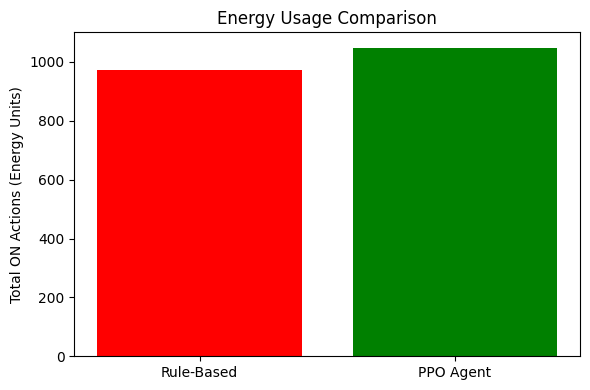

 Energy saved by PPO: -7.93%
Evaluation complete!


In [20]:
ppo_energy = df_log["Action"].sum()
baseline_energy = df_log["Baseline_Action"].sum()
saving = (baseline_energy - ppo_energy) / baseline_energy * 100

# Bar chart comparison
plt.figure(figsize=(6, 4))
plt.bar(["Rule-Based", "PPO Agent"], [baseline_energy, ppo_energy], color=["red", "green"])
plt.title("Energy Usage Comparison")
plt.ylabel("Total ON Actions (Energy Units)")
plt.tight_layout()
plt.show()

print(f" Energy saved by PPO: {saving:.2f}%")
print("Evaluation complete!")


Interpretation:
- The PPO agent turned ON the HVAC more often than the rule-based logic.

- Instead of saving energy, it resulted in 7.93% more energy usage.

- This is visualized clearly by the green bar being taller than the red bar.

Summary:
- The PPO agent still needs optimization.

- It's likely over-prioritizing comfort (e.g., acting too early or staying ON longer).

- Good start — but reward function or training time may need refinement.

# Pie Chart – HVAC ON vs. OFF (PPO Agent)

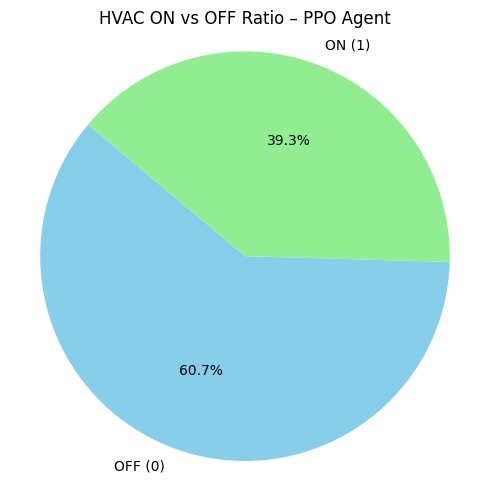

In [21]:
# Count ON vs OFF actions
action_counts = df_log["Action"].value_counts().sort_index()

labels = ["OFF (0)", "ON (1)"]
colors = ["skyblue", "lightgreen"]

plt.figure(figsize=(5, 5))
plt.pie(action_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("HVAC ON vs OFF Ratio – PPO Agent")
plt.axis("equal")
plt.tight_layout()
plt.show()


- The PPO agent kept the HVAC OFF most of the time (over 60%), which shows it tries to be energy-conscious.

- However, with nearly 40% ON time, it's still being relatively aggressive with HVAC usage.

- This aligns with your earlier result showing higher energy use than the rule-based method.

# Reward Over Time (PPO Agent)

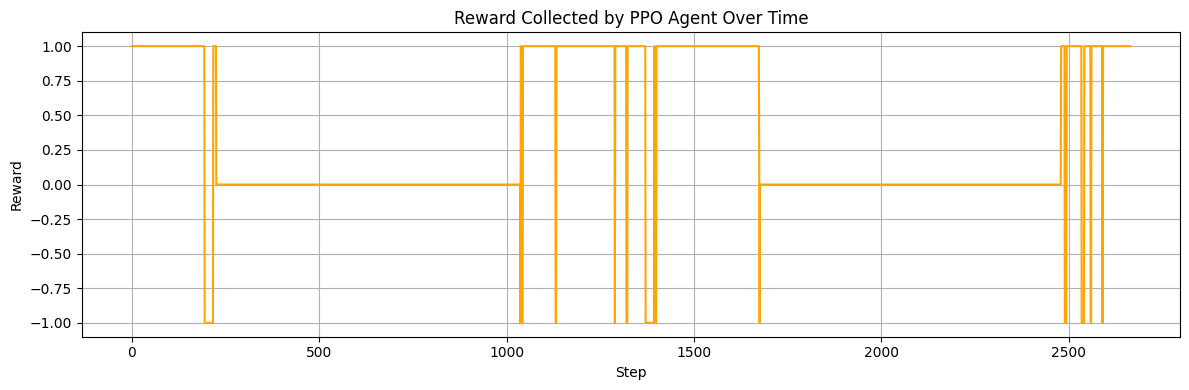

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(df_log["Step"], df_log["Reward"], color="orange")
plt.title("Reward Collected by PPO Agent Over Time")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretation:
- Flat regions at 0:
These mean the HVAC was OFF when no one was around — this is energy-efficient behavior (no penalty, no reward).

- Spikes to +1:
Represent moments when the agent correctly turned ON HVAC when someone was present — ideal comfort behavior.

- Dips to -1:
Represent mistakes — the agent turned ON HVAC when it wasn’t needed, causing energy waste.

Overall:
- Our PPO agent is mostly making smart decisions.

- Occasional dips to -1 suggest it's still learning or reacting too eagerly.

- These dips may be causing the higher energy usage seen earlier.